ibmqfactory.load_account:WARNING:2021-04-17 02:03:37,674: Credentials are already in use. The existing account in the session will be replaced.


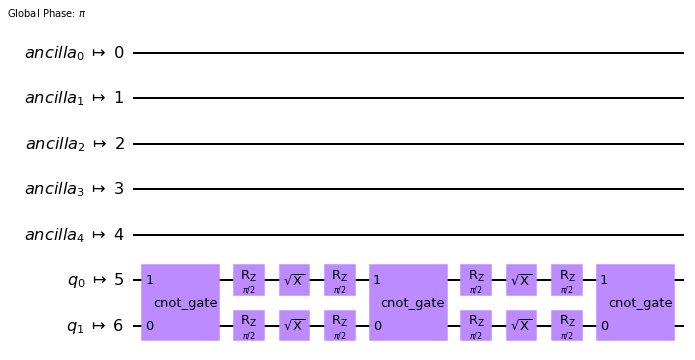

In [4]:
import numpy as np
# Importing standard Qiskit libraries
from qiskit import QuantumCircuit, transpile, Aer, IBMQ, schedule
from qiskit.tools.jupyter import *
from qiskit.visualization import *
from ibm_quantum_widgets import *
from qiskit.visualization.pulse_v2 import draw, IQXDebugging
from qiskit.providers.aer import QasmSimulator
from qiskit import pulse
from qiskit.pulse import DriveChannel, ControlChannel, Play, Schedule, Waveform
from qiskit.pulse.library import drag, GaussianSquare, Gaussian
from qiskit.circuit import Gate

##############################################################################################


IBMQ.load_account()
provider = IBMQ.get_provider(hub='ibm-q-community', group='ibmquantumawards', project='open-science')
backend = provider.get_backend('ibmq_casablanca')

################################################################################################

## load all the backend parameters for pulse
back_defaults = backend.defaults()
back_configuration = backend.configuration()
back_properties = backend.properties()
inst_map = back_defaults.instruction_schedule_map

dt = back_configuration.dt

#################################################################################################


control = 6
target = 5

##################################################################################################




# extracting the pre_CR instructions
cx_schedule = inst_map.get("cx", qubits=[control, target])
pre_instructions = cx_schedule.instructions[0:3]
#assert len(cr_instructions) == 5, f"{cr_instructions} should have 5 instructions"
#pre_instructions

#converting the pre_instructions to a schedule
pre_schedule = Schedule()
for (time, instruction) in pre_instructions:
    pre_schedule = pre_schedule.insert(time, instruction)
#draw(pre_schedule,style=IQXDebugging(), backend = backend) 
#

# extracting CR(pi/4) instructions

cx_schedule = inst_map.get("cx", qubits=[control, target])
cr_start_index = -1  
for i, (_, instruction) in enumerate(cx_schedule.instructions):
        # the Cross-Resonance within the CNOT starts with a GaussianSquare Play instruction
        if isinstance(instruction, Play):
            if isinstance(instruction.pulse, pulse.library.parametric_pulses.GaussianSquare):
                cr_start_index = i
                break  
assert cr_start_index != -1, "did not find the start of CR"    
cr_instructions = cx_schedule.instructions[cr_start_index:cr_start_index+2]
#cr_instructions

#CR(pi/8 pulse)
subtract_width = int(cr_instructions[1][1].pulse.width/2)

new_crp_pulse_duration = cr_instructions[1][1].pulse.duration - subtract_width
new_crp_pulse_amp = cr_instructions[1][1].pulse.amp
new_crp_pulse_sigma = cr_instructions[1][1].pulse.sigma
new_crp_pulse_width = cr_instructions[1][1].pulse.width - subtract_width
new_crp_pulse = GaussianSquare(duration = new_crp_pulse_duration, amp = new_crp_pulse_amp, sigma = new_crp_pulse_sigma, width = new_crp_pulse_width, name = 'new_crp_pulse') 


# CR(-pi/8) pulse
new_crm_pulse_duration = cr_instructions[1][1].pulse.duration - subtract_width
new_crm_pulse_amp = -cr_instructions[1][1].pulse.amp
new_crm_pulse_sigma = cr_instructions[1][1].pulse.sigma
new_crm_pulse_width = cr_instructions[1][1].pulse.width - subtract_width
new_crm_pulse = GaussianSquare(duration = new_crm_pulse_duration, amp = new_crm_pulse_amp, sigma = new_crm_pulse_sigma, width = new_crm_pulse_width, name = 'new_crm_pulse') 


#active cancellation plus pulse
new_cancelp_pulse_duration = cr_instructions[0][1].pulse.duration - subtract_width
new_cancelp_pulse_amp = cr_instructions[0][1].pulse.amp
new_cancelp_pulse_sigma = cr_instructions[0][1].pulse.sigma
new_cancelp_pulse_width = cr_instructions[0][1].pulse.width - subtract_width
new_cancelp_pulse = GaussianSquare(duration = new_cancelp_pulse_duration, amp = new_cancelp_pulse_amp, sigma = new_cancelp_pulse_sigma, width = new_cancelp_pulse_width, name = 'new_cancelp_pulse') 



# active cancellation minus pulse
new_cancelm_pulse_duration = cr_instructions[0][1].pulse.duration - subtract_width
new_cancelm_pulse_amp = -cr_instructions[0][1].pulse.amp
new_cancelm_pulse_sigma = cr_instructions[0][1].pulse.sigma
new_cancelm_pulse_width = cr_instructions[0][1].pulse.width - subtract_width
new_cancelm_pulse = GaussianSquare(duration = new_cancelm_pulse_duration, amp = new_cancelm_pulse_amp, sigma = new_cancelm_pulse_sigma, width = new_cancelm_pulse_width, name = 'new_cancelm_pulse') 



#creating the x_pulse for control qubit
x_schedule= inst_map.get('x', qubits=[control])
x_pulse_control = x_schedule.instructions[0][1].pulse


#creating the x_pulse for target qubit
x_schedule = inst_map.get('x', qubits=[target])
x_pulse_target = x_schedule.instructions[0][1].pulse


# build a cr(-pi/2) from cr(-pi/8) schedule 

with pulse.build(backend,name='CrossResonance') as cr_schedule:
    
    control_qubit_driveChannel = pulse.drive_channel(control) 
    target_qubit_driveChannel = pulse.drive_channel(target)
    control_channel = cr_instructions[1][1].channel
    
    pulse.play(x_pulse_control,control_qubit_driveChannel)
    
    pulse.delay(x_pulse_control.duration,control_channel)
    pulse.delay(x_pulse_control.duration,target_qubit_driveChannel)
    
    pulse.play(new_crp_pulse,control_channel) 
    pulse.play(new_cancelp_pulse,target_qubit_driveChannel)
    
    pulse.delay(new_crp_pulse.duration,control_qubit_driveChannel)
    
    pulse.play(x_pulse_control,control_qubit_driveChannel)
    
    pulse.delay(x_pulse_control.duration,control_channel)
    pulse.delay(x_pulse_control.duration,target_qubit_driveChannel)
    
    pulse.play(new_crm_pulse,control_channel)
    pulse.play(new_cancelm_pulse,target_qubit_driveChannel)
    
    pulse.delay(new_crm_pulse.duration,control_qubit_driveChannel)
    
    pulse.play(x_pulse_control,control_qubit_driveChannel)
    
    pulse.delay(x_pulse_control.duration,control_channel)
    pulse.delay(x_pulse_control.duration,target_qubit_driveChannel)
    
    pulse.play(new_crp_pulse,control_channel) 
    pulse.play(new_cancelp_pulse,target_qubit_driveChannel)
    
    pulse.delay(new_crp_pulse.duration,control_qubit_driveChannel)
    
    pulse.play(x_pulse_control,control_qubit_driveChannel)
    
    pulse.delay(x_pulse_control.duration,control_channel)
    pulse.delay(x_pulse_control.duration,target_qubit_driveChannel)
    
    pulse.play(new_crm_pulse,control_channel)
    pulse.play(new_cancelm_pulse,target_qubit_driveChannel)
    
    
#draw(cr_schedule, style=IQXDebugging(), backend = backend)    

# build a cnot schedule

cnot_schedule = Schedule()
cnot_schedule = pre_schedule + cr_schedule 
    
#draw(cnot_schedule, style=IQXDebugging(), backend = backend)    



###############################################################################################################




# Create abstract quantum gate of pulse schedule.
cnot_gate = Gate('cnot_gate', 2,[])

# Add cnot_gate to basis_gates and inst_map.
back_configuration.basis_gates += ['cnot_gate']
inst_map.add(cnot_gate, [control, target], cnot_schedule)


#back_configuration.basis_gates


##########################################################################################


qc_swap = QuantumCircuit(2)
qc = 1
qt = 0
#cnot_gate = Gate('cnot_gate', 2, [])
qc_swap.append(cnot_gate,(qc,qt))
qc_swap.h(qc)
qc_swap.h(qt)
qc_swap.append(cnot_gate,(qc,qt))
qc_swap.h(qc)
qc_swap.h(qt)
qc_swap.append(cnot_gate,(qc,qt))

#qc_swap.draw()

############################################################################################



qc_swap.add_calibration('cnot_gate',[control,target],cnot_schedule,[])
qc_swap=transpile(qc_swap, backend = backend, optimization_level=1, initial_layout=[5,6])
#transpiled_swap_circuit.draw()
qc_swap.draw()

################################################################################################

In [5]:
#swap_sched = schedule(transpiled_swap_circuit,backend, inst_map=inst_map)
#draw(swap_sched,style=IQXDebugging(), backend = backend)  